# Projet numérique : lignes de niveau   
*Sebastian Partarrieu & Antoine Dejoie*




In [8]:
import autograd
from autograd import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg  

## Trouver L'amorce
On implémente deux fonctions, une qui fonctionne par méthode de Newton et l'autre par dichotomie, pour trouver le réel $t \in [0,1]$ tel que $f(0,t) = c $.
Pour que la méthode de Newton converge correctement on suppose que la fonction $g:x \mapsto f(0,x)$ est bien convexe, strictement monotone sur $[0,1]$ et que $c \in [g(0), g(1)]$

On peut vérifier que la méthode va bien converger. On pose $h:x \mapsto g(x) - c$ définie sur $[0,1]$ avec $g$ (et donc $h$) possédant les "bonnes" propriétées énoncées ci-dessus. Sans perte de généralité, on peut aussi supposer que $g'> 0$ et donc que $h'>0$. On appelle $x_{0}$ le point d'annulation de $h$. On cherche à montrer que la suite définie par $ \left\{ \begin{array}{11} u_{n+1} = u_{n} - \frac{h(u_{n})}{h'(u_{n})} \\ u_{0} \in [x_{0},1] \end{array} \right.$ converge bien vers $x_{0}$ en étant décroissante (ou croissante si $u_{0} \in [0,x_{0}]$). 

On a $h' > 0$ et donc $\forall x \in ]x_{0},1]$, $h(x)>0$. Ainsi, $u_{n+1} \leq u_{n}$, la suite est bien décroissante. La suite est aussi minorée par $x_{0}$, on peut le voir visuellement avec le fait que la courbe de $h$ est au dessus de sa tangente en tout point et donc aucune tangente ne coupe l'axe des abscisses avant le point $x_{0}$. Ceci donne donc $\forall n$, $u_{n+1}\geq x_{0}$. La suite est décroissante et minorée, elle converge, on passe à la limite $l$ et on conclut que $h(l)=0$ et donc $l=x_{0}$ en utilisant les hypothèses sur $h$.



In [9]:
def find_seed(g, c, eps = 2**(-26)):
    if (g(0)<=c and g(1)>=c) or (g(0)>=c and g(1)<=c):
        f = lambda x: g(x) - c
        deriv_f = autograd.grad(f)
        x_0 = 1.0                           #L'initialisation a été arbitrairement choisie a 1.0 (flottant pour qua autograd fonctionne)
        g_1 = lambda x: x - f(x)/deriv_f(x)
        x_N = x_0
        x_N_plus_1 = g_1(x_0)
        while abs(x_N_plus_1 - x_N) > eps:
            x_N, x_N_plus_1 = x_N_plus_1, g_1(x_N_plus_1)
        return float((x_N_plus_1+x_N)/2)
    return None

On a aussi implémenté une fonction qui effectue la même tâche en fonctionnant par dichotomie pour palier au problème d'une possible annulation de la dérivée. Le principe est celui d'une dichotomie usuelle et on utilise encore une fonction possédant les bonnes propriétés. On se sert de cette fonction dans l'implémentation de contour.

In [10]:
def find_seed3(g, k,a0,b0, eps=2**(-26)):
    '''
    Methode dichotomie
    '''
    def fo(x):
        return(g(x)-k) 
    x=a0
    y=b0
    if  fo(a0)*fo(b0) < 0 :
        while abs(y-x) > eps:
            c=(x+y)/2
            if fo(c)*fo(x) < 0:
                y=c
            else :
                x=c
    if abs(fo(x))<0.01:
        return((x+y)/2)
    else:
        return None
        

## Implémentation de contour simple
Nous avons procédé, étapes par étapes, à l'implémentation de trois fonctions simple_contour différentes. 
### La première tentative
La première idée a été de diviser le carré $[0,1]$ avec un pas de $\delta$ et d'utiliser la fonction find_seed sur chaque droite verticale en changeant juste la paramétrisation de $f$ en fonction de l'abscisse sur laquelle on est.
Il existe plusieurs problèmes avec cette approche, la première étant qu'il peut exister plusieurs points $y \in [0,1]$ tels que $f(x_{i},y) = c$ et que find_seed ne nous renvoie qu'un seul point sur une même droite.
De plus, de façon "pratique", en testant sur quelque fonction simple la fonction simple_contour renvoie souvent des choses abérrantes, notamment avec la fonction tracée dans l'énoncé $(x,y) \mapsto 2(exp(-x^2 - y^2) - exp(-(x-1)^2 - (y-1)^2))$.

In [11]:
def simple_contour(f, c=0.0, delta = 0.01):
    nb_points = int(1/delta)
    tableau = np.linspace(0, 1, nb_points)
    abscisse = []
    ordonées = []
    for z in tableau:
        f_1 = lambda y: f(z,y)
        a = find_seed(f_1, c, 2**(-26))
        if a:
            ordonées.append(a)
            abscisse.append(z)     
    return abscisse, ordonées
    

**Test de la fonction simple_contour avec quelques fonctions** \
On test avec la fonction $(x,y) \mapsto x^2 + y^2$ et la fonction de l'énoncé.

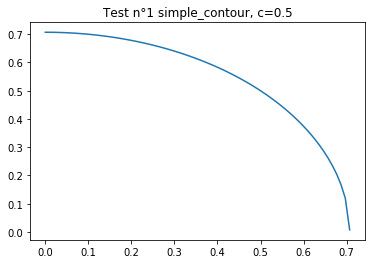

In [12]:
X0, Y0 = simple_contour(lambda x,y: x**2 + y**2, 0.5)
plt.plot(X0,Y0)
plt.title("Test n°1 simple_contour, c=0.5")
plt.show()

La fonction simple_contour marche donc approximativement avec la première fonction, même si on voit déjà un bout "non lisse" vers la fin du tracé. On comparera ultérieurement avec les autres fonctions et celle de matplotlib pour avoir un aperçu de l'erreur commise.\
On test maintenant avec la fonction de l'énoncé où le terminal annonce une division par zéro et affiche un graphe abbérant. Les limitations de notre première tentative deviennent vite claire et plutôt que d'essayer de remédier à ceci en s'assurant que la dérivée de notre fonction paramétrée ne s'annule pas nous avons choisi d'implémenter une autre méthode par la suite.


C:\Users\spart\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\spart\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),


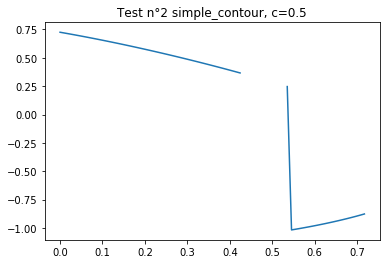

In [13]:
X00, Y00 = simple_contour(lambda x,y: 2*(np.exp(-x**2 - y**2) - np.exp(-(x-1)**2 - (y-1)**2)), 0.5)
plt.plot(X00,Y00)
plt.title("Test n°2 simple_contour, c=0.5")
plt.show()

### La deuxième tentative
Cette deuxième méthode se base sur le fait que le vecteur $\overrightarrow{\nabla}f(M) = \begin{pmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{pmatrix}$ est perpendiculaire à la courbe de niveau passant par le point M. Ainsi en prennant le vecteur $\overrightarrow{A} = \begin{pmatrix} -\frac{\partial f}{\partial y} \\ \frac{\partial f}{\partial x} \end{pmatrix}$ on a un vecteur tangent à la ligne de courbe de niveau. En définissant une convention telle qu'on ne sorte pas du cadre après l'amorce en assurant qu'on se déplace vers la droite, on peut effectuer un pas de distance delta dans la direction du vecteur tangent a la courbe. Ceci permet de suivre approximativement la courbe en effectuant une erreur sur chaque pas mais d'autant plus petite que $\delta$ est petit. On sort de la boucle lorsque les points ne sont plus dans la case ou si l'on revient au point de départ.



Le plus gros problème de cette fonction est l'erreur accumulée, qu'on va quantifier par la suite.


In [14]:
def gradient(f,x,y):
    p = autograd.grad
    return np.array([p(f,0)(x,y), p(f,1)(x,y)])

def simple_contour_2(f, c, delta = 0.01):
    '''
    Simple contour avec suivi de la tangente a la courbe. Problème avec l'erreur accumulé. Renvoie deux listes vides si on ne trouve pas d'amorce
    '''
    abscisse = []
    ordonnées = []
    x_0 = 0.0
    g = lambda y: f(x_0,y)
    y_0 = find_seed(g, c, 2**(-26))
    if not y_0 is None:
        x, y = x_0, y_0
        abscisse.append(x)
        ordonnées.append(y)
        convention = 1
        dx = gradient(f,x,y)[1] 
        if dx <= 0:              #On veut pas partir vers la gauche. Il faudra faire attention lorsqu'on va chercher sur tous les bords des cases. 
            convention = -1
        while (0 <= x <= 1 and 0 <= y <= 1): 
            dx = convention*gradient(f,x,y)[1]  
            dy = -convention*gradient(f,x,y)[0] 
            norme = (dx**2+dy**2)**0.5
            x+=dx*delta/norme
            y+=dy*delta/norme
            if (x,y) == (x_0,y_0):
                break
            else:
                abscisse.append(x)
                ordonnées.append(y)
    return abscisse, ordonnées

#### Test de la fonction simple_contour_2
On effectue des tests avec les mêmes fonctions que précédemment.

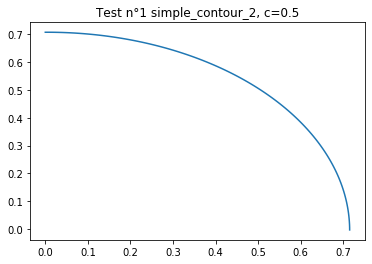

In [15]:
X1, Y1 = simple_contour_2(lambda x,y: x**2 + y**2, 0.5)
plt.plot(X1,Y1)
plt.title("Test n°1 simple_contour_2, c=0.5")
plt.show()

On remarque déjà à ce stade qu'on n'a pas de problème de parties "non lisses" vers la fin du tracé (à droite dans le graphique) avec cette méthode

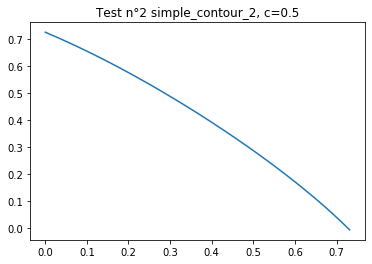

In [16]:
X2, Y2 = simple_contour_2(lambda x,y: 2*(np.exp(-x**2 - y**2) - np.exp(-(x-1)**2 - (y-1)**2)), 0.5)
plt.plot(X2,Y2)
plt.title("Test n°2 simple_contour_2, c=0.5")
plt.show()

Ouf... cette fonction fonctionne bien avec l'exemple donné par l'énoncé et renvoie quelque chose de tout à fait cohérent. Reste à voir si cette méthode est précise, il nous à été indiqué qu'avec cette implémentation, la fonction contour pour $(x,y) \mapsto x^2 + y^2$ ne renvoie pas un vrai cercle mais un cercle avec des discontinuités au niveau des raccords entre différentes cellules.

### Troisième tentative
Pour être sur d'avoir une précision maximale nous avons repris l'idée de la fonction précédente mais au lieu de rester sur le point $(x_{faux},y_{faux})$ donné par le vecteur tangent à la courbe et situé à la distance $\delta$ du point précédent, il s'agit d'effectuer une autre méthode de Newton à partir de ce point $(x_{faux},y_{faux})$ sur la fonction $g:(x,y) \mapsto (f(x,y)-c, (x-x_{0})^2 + (y-y_{0})^2 - \delta ^2)$ où $(x_{0},y_{0})$ représente le premier point (celui déjà situé sur la courbe de niveau).

L'idée est de trouver le point qui vérifie à la fois $f(x,y) = c$ et l'équation du cercle de rayon $\delta$ et de centre le point déjà sur la courbe de niveau, $(x-x_{0})^2 + (y-y_{0})^2 = \delta ^2$.

On implémente une fonction à part pour effectuer la méthode de Newton. Nous ne procéderons pas à la démonstration que celle-ci converge bien pour des fonctions à plusieurs variables, on se contentera de la convergence observée en pratique qui est aidée par le fait que le point à partir duquel on "part" est déjà proche du point réellement situé sur la courbe de niveau. 
On utilise la relation de récurrence sur des vecteurs $X_{n+1} = X_{n} - J_{f}^{-1}(X_{n})f(X_{n})$

In [17]:
def Newton_deux_variables(g, x_faux, y_faux, eps = 2**(-26)): 
    '''
    Implémente la méthode de Newton pour la fonction g_2 ci-dessous. La fonction est prise convexe, monotone et continument différentiable.
    '''
    X_0 = np.array([x_faux, y_faux])
    def Jacob(x,y):
        j = autograd.jacobian
        return np.c_[j(g, 0)(x,y), j(g, 1)(x,y)]
    jacob_g = Jacob(x_faux, y_faux)
    inv_jacob_g = np.linalg.inv(jacob_g)
    X_1 = X_0 - np.dot(inv_jacob_g, g(X_0[0],X_0[1]))
    while np.linalg.norm(X_1 - X_0) > eps:
        A = X_1 - np.dot(inv_jacob_g, g(X_1[0], X_1[1]))
        X_0, X_1 = X_1, A
    return X_1 


def simple_contour_3(f, c, delta = 0.01):
    '''
    Implémente une double méthode de Newton avec une fonction renvoyant la valeur de f et l'équation associée à un cercle de rayon de delta. 
    Pour le premier point à partir duquel on commence Newton on prend le point sur le cercle de rayon delta et dans la direction de la tangente à la courbe.
    '''
    x_0 = 0.0
    g_1 = lambda y: f(x_0, y)   #Pour trouver l'amorce
    y_0 = find_seed(g_1, c, 2**(-26))
    abscisse = []
    ordonées = []
    if not y_0 is None:   #et pas if y_0 au cas où y_0 = 0
        x_ref = x_0       #pour ne pas repasser par le même point
        y_ref = y_0
        dx_0 = gradient(f,x_0,y_0)[1]
        convention = 1
        if dx_0 <= 0:    #pour partir à droite
            convention = -1
        abscisse.append(x_0)
        ordonées.append(y_0)
        def g_2(x,y):     
            return np.array([f(x,y)-c, (x-x_0)**2 + (y-y_0)**2 - delta**2])
        while (0 <= x_0 <= 1 and 0 <= y_0 <= 1):
            dx = gradient(f,x_0,y_0)[1]
            dy = -gradient(f,x_0,y_0)[0] 
            norme = (dx**2+dy**2)**0.5
            x_faux = x_0 + dx*convention*delta/norme   #les coordonnées du point sur la tangente a la courbe
            y_faux = y_0 + dy*convention*delta/norme
            nouveau_point = Newton_deux_variables(g_2, x_faux, y_faux)
            x_0 = nouveau_point[0]
            y_0 = nouveau_point[1]
            if (x_0,y_0) == (x_ref, y_ref):
                break
            else:
                abscisse.append(x_0)
                ordonées.append(y_0)
    return abscisse, ordonées

#### Test de la fonction simple_contour_3
On effectue les mêmes test qu'avec les fonctions précédentes. On voit que cette implémentation est aussi "lisse" et ne recontre pas de problème avec la fonction fournie par l'énoncé.

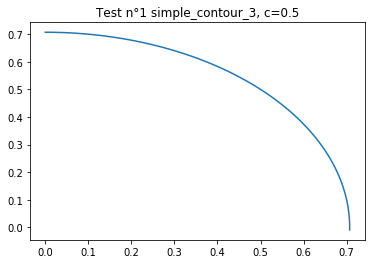

In [18]:
X3, Y3 = simple_contour_3(lambda x,y: x**2 + y**2, 0.5)
plt.plot(X3,Y3)
plt.title("Test n°1 simple_contour_3, c=0.5")
plt.show()

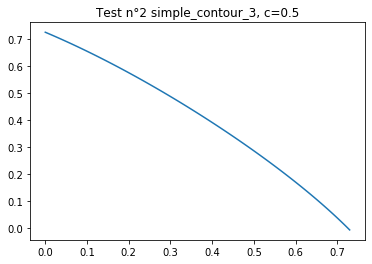

In [19]:
X4, Y4 = simple_contour_3(lambda x,y: 2*(np.exp(-x**2 - y**2) - np.exp(-(x-1)**2 - (y-1)**2)), 0.5)
plt.plot(X4,Y4)
plt.title("Test n°2 simple_contour_3, c=0.5")
plt.show()

## Comparaison d'erreur entre les différentes implémentations de simple contour
On prendra comme valeurs de référence les valeurs données par la fonction contour de matplotlib. On s'assure tout d'abord que celle-ci fonctionne comme prévu.

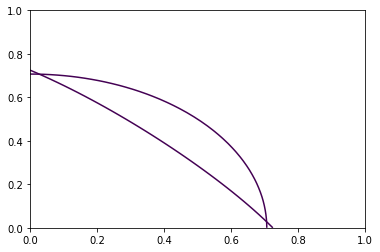

In [20]:
x = np.linspace(0.0,1.0,50)
y = np.linspace(0.0,1.0,50)
X5, Y5 = np.meshgrid(x,y)
Z1 = 2*(np.exp(-X5**2 - Y5**2) - np.exp(-(X5-1)**2 - (Y5-1)**2))
Z2 = X5**2 + Y5**2
plt.contour(X5, Y5, Z1, [0.5])
plt.contour(X5,Y5, Z2 ,[0.5])
plt.show()

**Comparaison de l'erreur pour la fonction** $f:(x,y) \mapsto 2(exp(-x^2 - y^2) - exp(-(x-1)^2 - (y-1)^2))$
Initialement on voulait prendre pour l'erreur la norme $\rvert\overrightarrow{\mu}\rvert = \sqrt{(x_{simplecontour} - x_{matplotlib})^2 + (y_{simplecontour} - y_{matplotlib})^2}$ pour les différents x et y fournis par nos méthodes simplecontour différentes. Cependant vu que les points ne sont pas forcéments espacés de la même manière entre contour de matplotlib et nos fonctions simple contour ceci ne fonctionne pas.

On se contentera de tracer sur le même graphique les différents bouts de contour obtenu avec simple_contour_2 et simple_contour_3 (la première n'est pas prise car elle renvoie des absurdités sur cet exemple) mais ceci ne fournit pas une mesure quantitative de l'erreur. De plus, on observe seulement le fait que les deux méthodes 2 et 3 fonctionnent "bien".

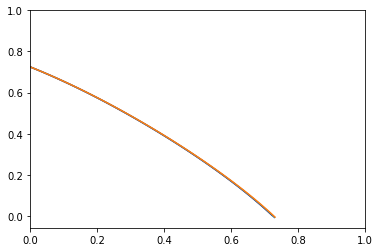

In [21]:
plt.contour(X5, Y5, Z1, [0.5])
plt.plot(X4,Y4)
plt.plot(X2,Y2)

## Implémentation de la fonction contour complexe
En s'inspirant de la fonction simple_contour_3 nous avons implémenté la fonction contour qui permet de tracer un contour sur un domaine qui n'est plus nécessairement $[0,1]\times[0,1]$. On a rencontré plusieurs difficultés dans l'implémentation de cette fonction. 

Tout d'abord le test effectué précédemment (juste sur le signe de dx pour ne pas partir à gauche) pour établir la convention (et donc le vecteur qu'on va "suivre" en effectuant le newton simultanément) ne fonctionne pas car on recherche des amorces sur les quatres côtés des carrés, et il faudra donc partir à gauche si par exemple l'amorce est sur le côté droit du carré.  Il faut effectuer un autre type de test pour pouvoir partir dans le "bon" sens. On a choisit d'effectuer un simple test d'appartenance au carré, c'est à dire que l'on calcule les deux points possibles situé sur la tangente à la courbe en l'amorce et on définie la convention prise en fonction du point qui est dans le carré.


In [22]:
def vecteur_i(f,X,xi,xi1,yj,yj1,delta):   #X !=none
    '''
    donne la convention à prendre pour se déplacer dans le bon sens
    '''
    def grad_f(x,y):
        h=autograd.grad
        return np.r_[h(f,0)(x,y),h(f,1)(x,y)]
    
    X=np.array(X)
    n=grad_f(X[0],X[1])
    norme = (n[0]**2 + n[1]**2)**0.5
    v1=np.array([n[1],-n[0]])
    v2=np.array([-n[1],n[0]])
    X1=X+v1*delta/norme
    if X1[0]>xi and X1[0]<xi1 and X1[1]>yj and X1[1]<yj1:
        return(-1)    #methode du vecteur tangent b,-a
    else:
        return(1)   #méthode du vecteur tangent -b,a

On regarde successivements les bords du carré et on prend le premier bord sur lequel on trouve une amorce avec la fonction find_seed3 qui implémente une méthode dichotomique.

In [23]:
def ammorce(f,xi,xi1,yj,yj1,c):
    '''
    cherche une ammorce sur chacun des bords du carré xi xi1 xj xj1
    '''
    z=None
    i=0
    while not z and i<4:
    
        if i==0:
            def g(y):
                return(f(xi,y))
            z=find_seed3(g,c,yj,yj1)
             
            X=[xi,z]
        elif i==1:
            def g(y):
                return(f(xi1,y))
            z=find_seed3(g,c,yj,yj1)
            X=[xi1,z]
        elif i==2:
            def g(y):
                return(f(y,yj))
            z=find_seed3(g,c,xi,xi1)
            X=[z,yj]
        else:
            def g(y):
                return(f(y,yj1))
            z=find_seed3(g,c,xi,xi1)
            X=[z,yj1]
        i+=1
    return(X)

Implémentation de la fonction contour qui consiste à itérer le processus de simple_contour_3 sur des "petits" carrés et de rattacher tous les bouts afin de pouvoir tracé le contour général.

In [24]:
def contour(f,c=0.0,xc=[-1.0,0.0,1.0],yc=[-1.0,0.0,1.0],delta=0.01):
    lx=[]
    ly=[]
    n=len(xc)
    m=len(yc)
    for i in range(n-1):
        for j in range(m-1):
            xs=[]
            ys=[]
            xi=xc[i]
            xi1=xc[i+1]
            yj=yc[j]
            yj1=yc[j+1]
            
            X=ammorce(f,xi,xi1,yj,yj1,c)
            X=np.array(X)
            
            if X.all() != None:
                xs.append(X[0])
                ys.append(X[1])
                convention=vecteur_i(f,X,xi,xi1,yj,yj1,delta)
                x_0=X[0]
                y_0=X[1]
                
                def g_2(x,y):     
                    return np.array([f(x,y)-c, (x-x_0)**2 + (y-y_0)**2 - delta**2])
                    
                while xi<=x_0<=xi1 and yj<=y_0<=yj1:
                    
                    dx = -gradient(f,x_0,y_0)[1]
                    dy = gradient(f,x_0,y_0)[0] 
                    norme = (dx**2+dy**2)**0.5
                    x_faux = x_0 + dx*convention*delta/norme
                    y_faux = y_0 + dy*convention*delta/norme
                    nouveau_point = Newton_deux_variables(g_2, x_faux, y_faux)
                    x_0 = nouveau_point[0]
                    y_0 = nouveau_point[1]
                    xs.append(x_0)
                    ys.append(y_0)        
            lx.append(xs)
            ly.append(ys)
    return(lx,ly)

In [25]:
def f(x,y):
    return(np.exp(-x**2-y**2))
    
def g(x,y):
    return(np.exp(-(x-1)**2-(y-1)**2))
    
def h(x,y):
    return(2*(f(x,y)-g(x,y)))
    
def cercle(x,y):
    return(x**2+y**2)
    

### Test de notre fonction contour
On effectue des tests sur les deux mêmes fonctions que précedemment mais cette fois ci on prend un domaine plus large. On prend tout d'abord le domaine $[-1,1]$.  lx et ly contiennent des listes de listes avec chaque sous liste contenant une série d'abscisses et d'ordonnées d'un sous carré.
On effectue un premier test sur la fonction $f:(x,y) \mapsto x^2 +y^2$. On trace plusieurs lignes de niveaux. La fonction contour marche donc sur l'exemple le plus "basique" de fonction.

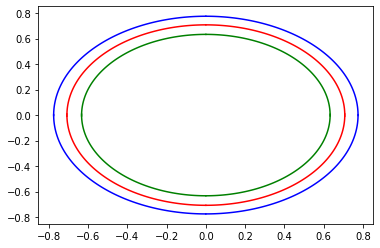

In [31]:
lx1,ly1 = contour(cercle, 0.5)
lx2,ly2 = contour(cercle, 0.6)
lx3,ly3 = contour(cercle, 0.4)
plt.figure()
q=len(lx1)
for a in range(len(lx1)):   #on pourrait faire avec un 
    plt.plot(lx1[a],ly1[a],'r')
    plt.plot(lx2[a],ly2[a],'b')
    plt.plot(lx3[a],ly3[a],'g')
plt.show()

On effectue ensuite un test de la fonction contour pour la fonction fournie par l'énoncé.

Text(0.5, 1.0, 'Test contour pour h et c=1.0')

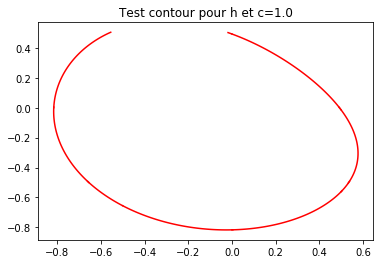

In [32]:
lx4, ly4 = contour(h, 1.0, xc = [-2.0+0.5*k for k in range(8)], yc = [-1.0+0.5*k for k in range(4)])
plt.figure()
q = len(lx4)
for a in range(len(lx4)):   #on pourrait faire zip
    plt.plot(lx4[a], ly4[a], 'r')
plt.title("Test contour pour h et c=1.0")

On essaie finalement de tracer le même ensemble de contour que le fait l'énoncé. On constate que ça fonctionne assez bien sauf pour la valeur c=0.0, ça nous renvoie une erreur.

In [33]:
lx6, ly6 = contour(h, 0.5, [-2 + 0.5*k for k in range(11)], [-1 + 0.5*k for k in range(7)])
lx7, ly7 = contour(h, 1.0, [-2 + 0.5*k for k in range(11)], [-1 + 0.5*k for k in range(7)])
lx8, ly8 = contour(h, 1.5, [-2 + 0.5*k for k in range(11)], [-1 + 0.5*k for k in range(7)])
lx9, ly9 = contour(h, -0.5, [-2 + 0.5*k for k in range(11)], [-1 + 0.5*k for k in range(7)])
lx10, ly10 = contour(h, -1.0, [-2 + 0.5*k for k in range(11)], [-1 + 0.5*k for k in range(7)])
lx11, ly11 = contour(h, -1.5, [-2 + 0.5*k for k in range(11)], [-1 + 0.5*k for k in range(7)])

Text(0.5, 1.0, 'Tracé final avec notre fonction contour')

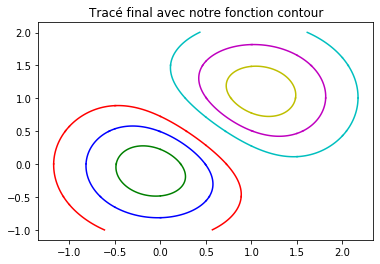

In [34]:
plt.figure()
q = len(lx6)
for a in range(len(lx6)):   #on pourrait faire zip
    plt.plot(lx6[a], ly6[a], 'r')
    plt.plot(lx7[a], ly7[a], 'b')
    plt.plot(lx8[a], ly8[a], 'g')
    plt.plot(lx9[a], ly9[a], 'c')
    plt.plot(lx10[a], ly10[a], 'm')
    plt.plot(lx11[a], ly11[a], 'y')
plt.title("Tracé final avec notre fonction contour")
    

## Petit Bonus : Visualisation 3D 

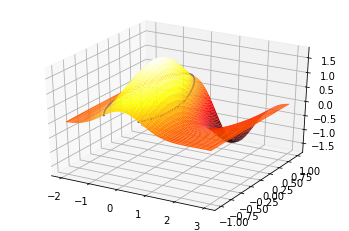

In [35]:
from mpl_toolkits.mplot3d import Axes3D
lx,ly=contour(h,0.5,xc=[-2.0+0.5*k for k in range(10)],yc=[-1.0+0.5*k for k in range(6)])
Lx = np.linspace(-2, 3)   
Ly = np.linspace(-1, 1) 
X, Y = np.meshgrid(Lx, Ly) 
Z = h(X,Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
for a in range(len(lx)):
    la,lb=lx[a],ly[a]
    lc=np.array([0.5 for k in range(len(la))])
    ax.plot(np.array(la),np.array(lb),lc,'b')

ax.plot_surface(X, Y, Z, cmap='hot')
plt.show()